In [ ]:
"""Test classifier on a new document."""
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import sys
sys.path.insert(0, "/home/pdipasquale/MIIA/stuff")

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
from safetensors.torch import load_file
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor

# Paths
NAME = "exp2-weighted-loss-qwen3"


BASE_PATH = Path("/home/pdipasquale/MIIA/stuff")
MODEL_NAME = "Qwen/Qwen2.5-VL-3B-Instruct"
CLASSIFIER_PATH = BASE_PATH / "hf/models/{NAME}/head/classifier_head.safetensors"
DEVICE = "cuda"
THRESHOLD = 0.5  # Lower = fewer false negatives

/home/pdipasquale/MIIA/stuff/.stuff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# VLMClassifier class
class VLMClassifier(nn.Module):
    def __init__(self, base_model, hidden_size=None, num_labels=2):
        super().__init__()
        self.base_model = base_model
        hidden_size = hidden_size or base_model.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )
        
    def forward(self, input_ids, attention_mask, pixel_values, image_grid_thw):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            image_grid_thw=image_grid_thw,
            output_hidden_states=True,
            return_dict=True
        )
        hidden_states = outputs.hidden_states[-1]
        pooled = hidden_states.mean(dim=1)
        logits = self.classifier(pooled.float())
        return logits

In [3]:
# Load model
processor = AutoProcessor.from_pretrained(MODEL_NAME)
base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    MODEL_NAME, torch_dtype=torch.bfloat16, device_map="cuda:0"
)
model = VLMClassifier(base_model, num_labels=2).to(DEVICE)
model.classifier.load_state_dict(load_file(CLASSIFIER_PATH))
model.eval()
print("✓ Model loaded")

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


✓ Model loaded


In [31]:
# Pick a document NOT in training
from src.processing import extract_tables_from_output

# tabella spezzata:
# 1002517_2012_0001193125-12-502218
# 1004673_2010_0001104659-10-034520
# 1062047_2008_0001193125-08-053678
# 1101661_2007_0001140905-07-000026
# 1125920_2008_0001125920-08-000015
# 1127371_2012_0001145443-12-000334
# 1178409_2012_0001104659-12-025412
# 1262279_2005_0001104659-05-046870

# Use a document from output that wasn't in sct_docs
TEST_DOC = "1125920_2008_0001125920-08-000015"  # Change this
DOC_PATH = BASE_PATH / "output" / TEST_DOC
VLM_PATH = DOC_PATH / TEST_DOC / "vlm"

# Extract tables (returns tuple: tables, stats)
tables, _ = extract_tables_from_output(DOC_PATH, save_path="/dev/null")
print(f"Found {len(tables)} tables in {TEST_DOC}")

=== Extraction Summary ===
Total output directories: 1
  - MinerU processed: 1
  - MinerU NOT processed (no content_list.json): 0

Of processed documents:
  - With tables: 1
  - Without tables: 0

Total tables extracted: 17
Found 17 tables in 1125920_2008_0001125920-08-000015


In [32]:
# Classify all tables
def classify_table(img_path):
    img = Image.open(img_path).convert("RGB")
    messages = [[{
        "role": "user",
        "content": [
            {"type": "image", "image": img},
            {"type": "text", "text": "Classify this table."}
        ]
    }]]
    texts = [processor.apply_chat_template(m, tokenize=False, add_generation_prompt=True) for m in messages]
    inputs = processor(text=texts, images=[img], padding=True, return_tensors="pt")
    
    with torch.no_grad():
        input_ids = inputs["input_ids"].to(DEVICE)
        attention_mask = inputs["attention_mask"].to(DEVICE)
        pixel_values = inputs["pixel_values"].to(DEVICE, dtype=torch.bfloat16)
        image_grid_thw = inputs["image_grid_thw"].to(DEVICE)
        logits = model(input_ids, attention_mask, pixel_values, image_grid_thw)
        probs = F.softmax(logits, dim=-1)
        
    return probs[0, 1].item()  # P(sct)

# Classify
results = []
for t in tqdm(tables, desc="Classifying"):
    img_path = VLM_PATH / t.get("img_path", "")
    if img_path.exists():
        prob = classify_table(img_path)
        is_sct = prob >= THRESHOLD
        results.append({"table": t, "prob": prob, "is_sct": is_sct, "img_path": img_path})
        
sct_tables = [r for r in results if r["is_sct"]]
print(f"\nFound {len(sct_tables)} SCT tables (threshold={THRESHOLD})")

Classifying: 100%|██████████| 17/17 [00:01<00:00, 10.35it/s]


Found 2 SCT tables (threshold=0.3)



=== SCT 1 (prob=0.961) ===


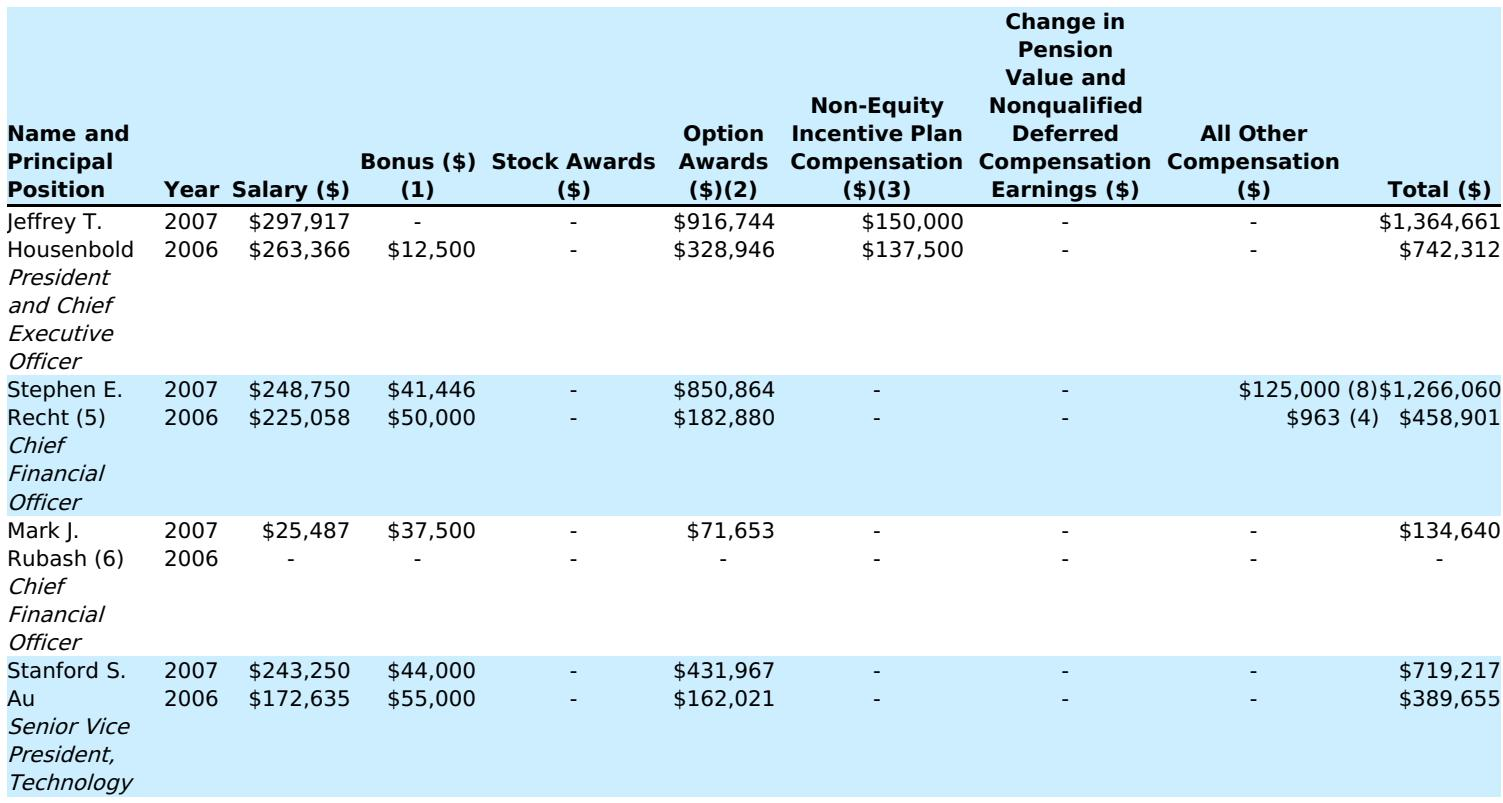


=== SCT 2 (prob=0.892) ===


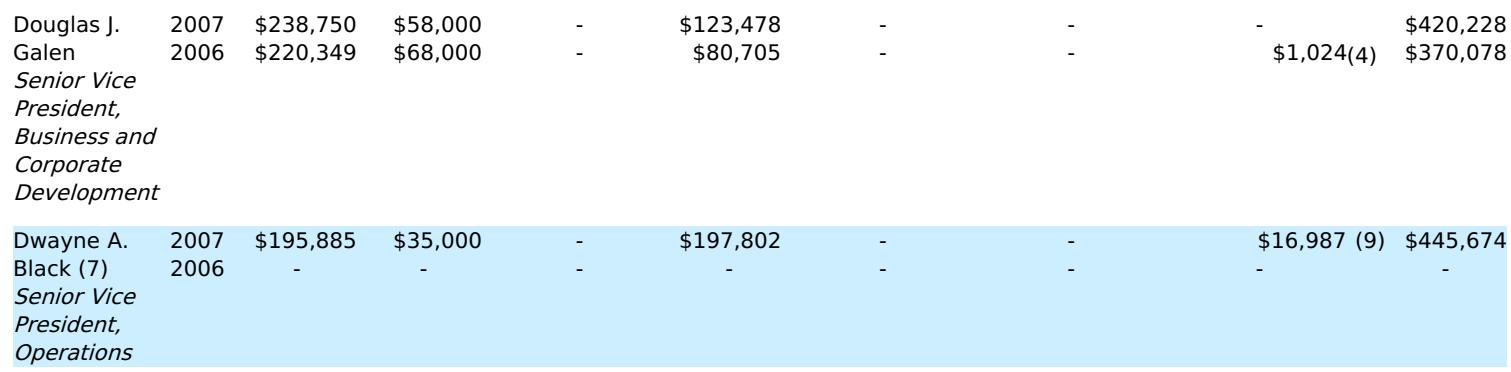

In [34]:
# Show SCT tables
for i, r in enumerate(sct_tables):
    print(f"\n=== SCT {i+1} (prob={r['prob']:.3f}) ===")
    display(Image.open(r["img_path"]))


=== Table 1: SCT (prob=0.961) ===


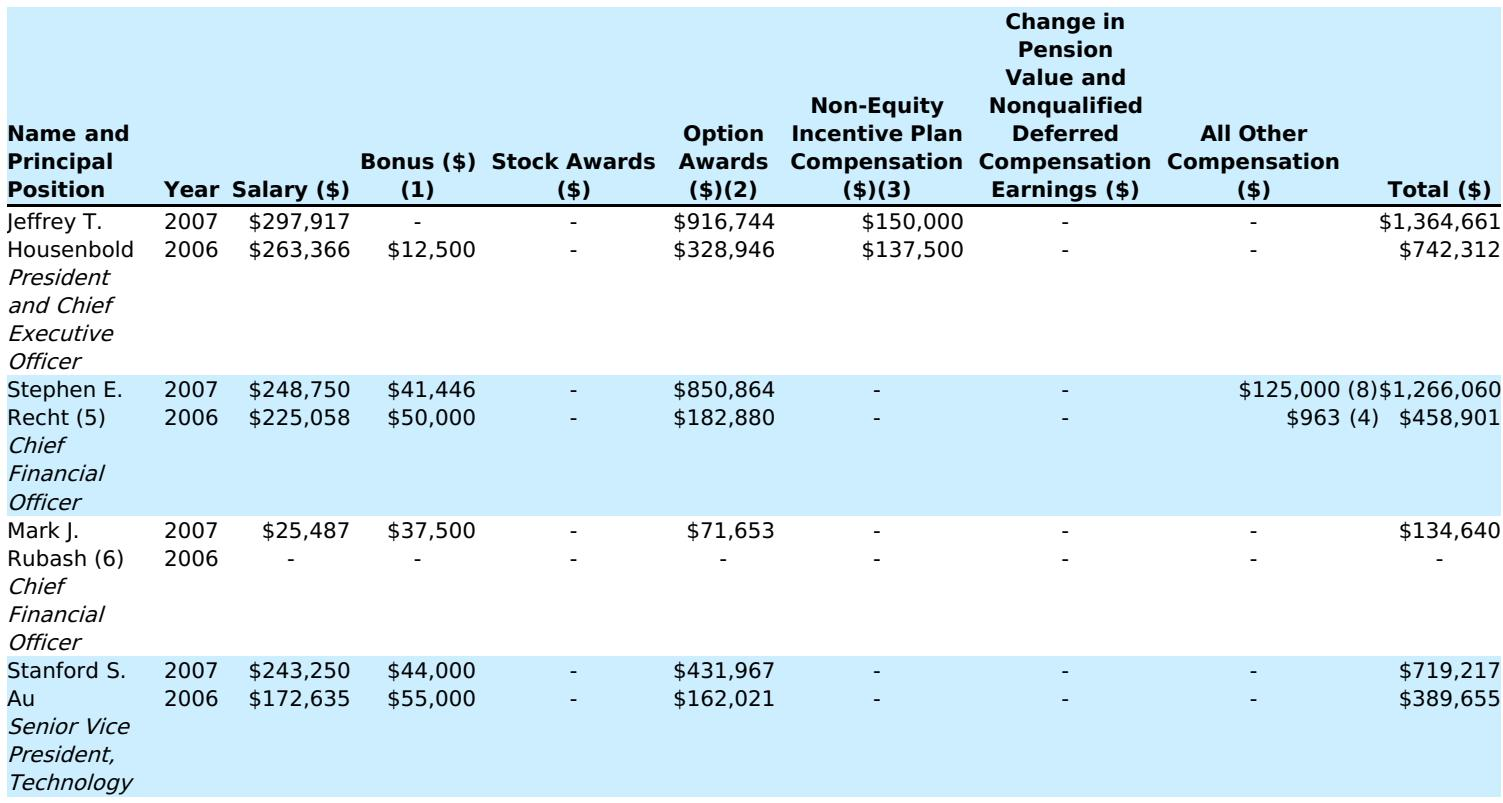


=== Table 2: SCT (prob=0.892) ===


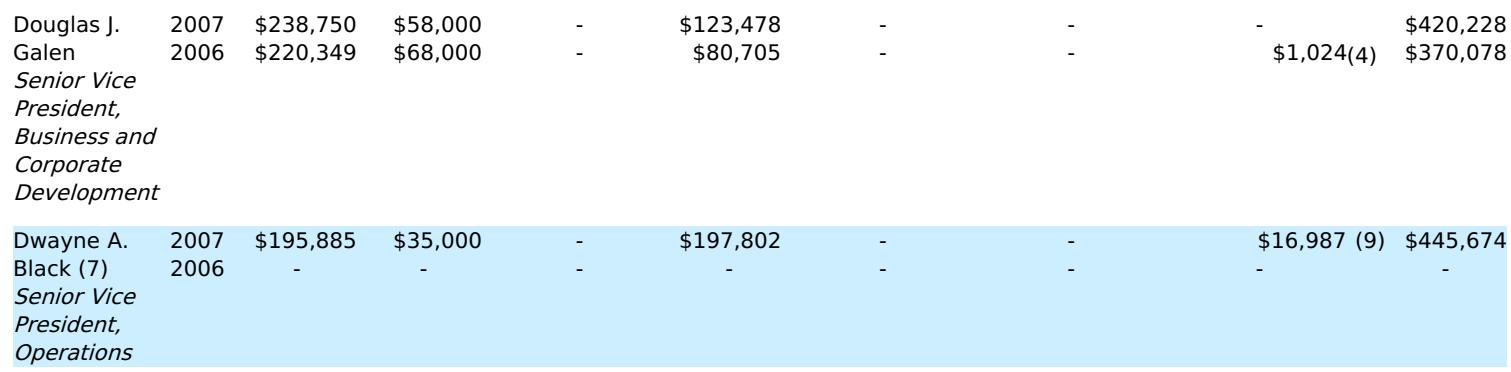


=== Table 3: non-SCT (prob=0.128) ===


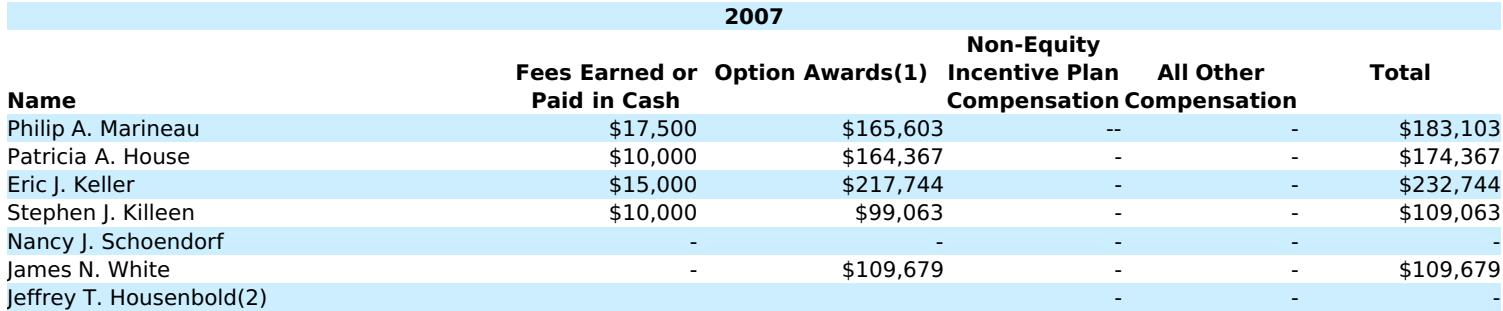

In [35]:
# Show all tables sorted by probability
results_sorted = sorted(results, key=lambda x: x["prob"], reverse=True)
for i, r in enumerate(results_sorted[:3]):
    label = "SCT" if r["is_sct"] else "non-SCT"
    print(f"\n=== Table {i+1}: {label} (prob={r['prob']:.3f}) ===")
    display(Image.open(r["img_path"]))